## Setup

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import sklearn
sns.set_theme()
# %matplotlib inline

# Surpress warnings:
# def warn(*args, **kwargs):
#     pass
# import warnings
# warnings.warn = warn

In the following cells we will load the data and define some useful plotting functions.


In [2]:
np.random.seed(72018)


def to_2d(array):
    return array.reshape(array.shape[0], -1)
    
def plot_exponential_data():
    data = np.exp(np.random.normal(size=1000))
    plt.hist(data)
    plt.show()
    return data
    
def plot_square_normal_data():
    data = np.square(np.random.normal(loc=5, size=1000))
    plt.hist(data)
    plt.show()
    return data

In [19]:
def get_k2test_pvalue(data, round_digits=6):
    test = stats.mstats.normaltest(data).pvalue
    if round_digits is not None:
        test = test.round(round_digits).item()
    return test

In [ ]:
# !wget "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML240EN-SkillsNetwork/labs/data/boston_housing_clean.pickle"

### Loading the Boston Housing Data


In [3]:
filename = 'data/boston_housing_clean.pickle'
with open(filename, 'rb') as to_read:
    boston = pd.read_pickle(to_read)
boston_data = boston['dataframe']
boston_description = boston['description']

In [6]:
boston_data.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7


In [4]:
boston_data.shape

(506, 14)

## EDA

### Determining Normality


Making our target variable normally distributed often will lead to better results

If our target is not normally distributed, we can apply a transformation to it and then fit our regression to predict the transformed values.

How can we tell if our target is normally distributed? There are two ways:

* Using a Visual approach
* Using a Statistical Test


#### Using a Visual approach


#### Plotting a histogram:


In [ ]:
# boston_data.MEDV.hist();

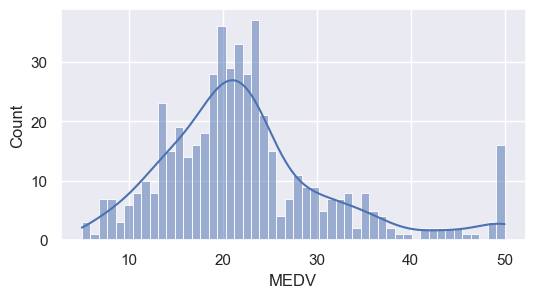

In [5]:
# Plot a histogram of the `MEDV` column using seaborn with KDE=True
plt.figure(figsize=(6, 3))
sns.histplot(boston_data.MEDV, kde=True, bins=50);

The histogram does not look normal due to its right tail.


#### Using a Statistical Test


Without getting into Bayesian vs. frequentist debates, for the purposes of this lesson, the following will suffice:

* This is a statistical test that tests whether a distribution is normally distributed or not. It isn't perfect, but suffice it to say: 
    * This test outputs a **p-value**. The _higher_ this p-value is the _closer_ the distribution is to normal.
    * Frequentist statisticians would say that you accept that the distribution is normal (more specifically: fail to reject the null hypothesis that it is normal) if p > 0.05.


In [6]:
from scipy.stats.mstats import normaltest # D'Agostino K^2 Test

In [21]:
# normaltest(boston_data.MEDV.values)
get_k2test_pvalue(boston_data['MEDV'], round_digits=None)

np.float64(1.7583188871696095e-20)

p-value is _extremely_ low. Our **y** variable which we have been dealing with this whole time was not normally distributed!


### Apply transformations to make target variable more normally distributed for Regression


Linear Regression assumes a normally distributed residuals which can be aided by transforming **y** variable which is the target variable. Let's try some common transformations to try and get **y** to be normally distributed: 

* Log Transformation
* Square root Transformation
* Box cox Transformation


### Log Transformation


The log transformation can transform data that is significantly skewed right to be more normally distributed:


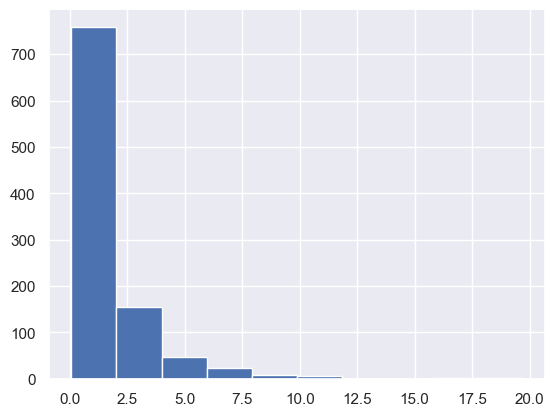

In [23]:
data = plot_exponential_data()

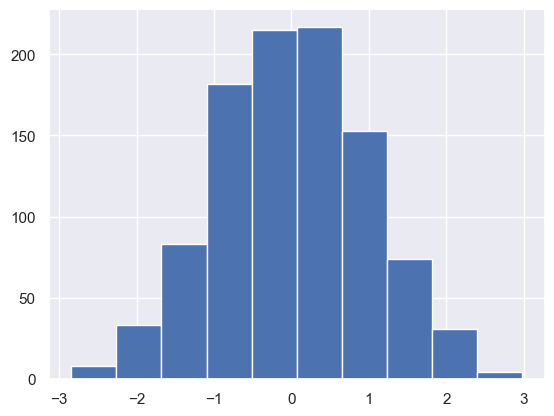

In [24]:
plt.hist(np.log(data));

**Apply transformation to Boston Housing data:**


In [8]:
log_medv = np.log(boston_data.MEDV)

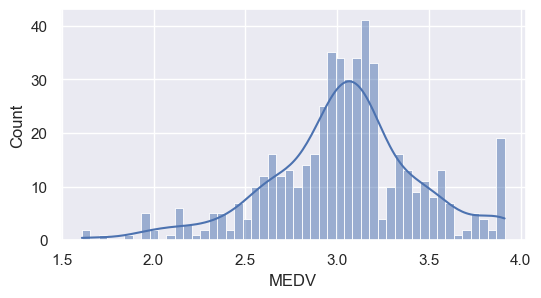

In [9]:
plt.figure(figsize=(6, 3))
sns.histplot(log_medv, kde=True, bins=50);

In [22]:
# normaltest(log_medv)
get_k2test_pvalue(log_medv)

0.000182

Conclusion: The output is closer to normal distribution, but still not completely normal.


### Square root Transformation

The square root transformation is another transformation that can transform non-normally distributed data into normally distributed data:


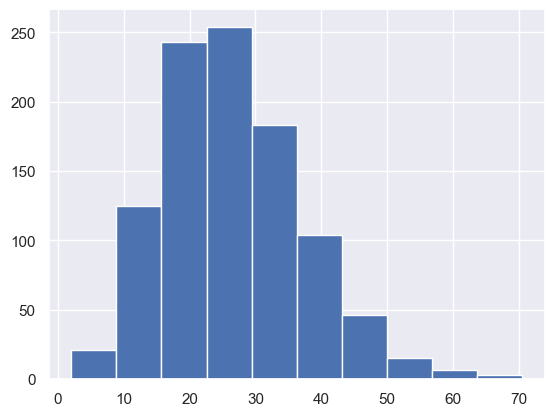

In [30]:
data = plot_square_normal_data()

You may notice that the output still exhibits a slight right skew.


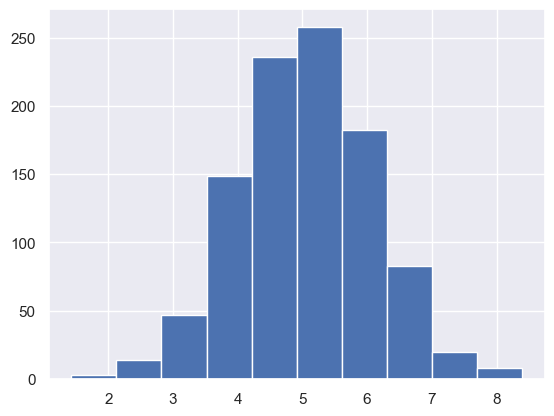

In [31]:
plt.hist(np.sqrt(data));

#### Exercise


Apply the square root transformation to the Boston Housing data target and test whether the result is normally distributed.


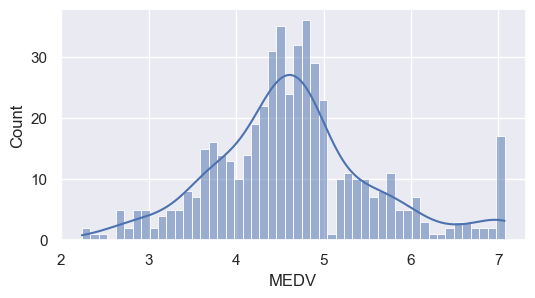

In [23]:
# Apply the square root transformation to the Boston Housing data target MEDV
# and plot the transformed data using seaborn with kde=True
sqrt_medv = np.sqrt(boston_data.MEDV)
plt.figure(figsize=(6, 3))
sns.histplot(sqrt_medv, kde=True, bins=50);

<details><summary>Click here for a sample python solution</summary>

```python
sqrt_medv = np.sqrt(boston_data.MEDV)
plt.hist(sqrt_medv)

```


In [24]:
# normaltest(sqrt_medv)
get_k2test_pvalue(sqrt_medv)

3.6e-05

### Box cox Transformation


The box cox transformation is a parametrized transformation that tries to get distributions "as close to a normal distribution as possible".

It is defined as:

$$ \text{boxcox}(y_i) = \frac{y_i^{\lambda} - 1}{\lambda} $$

You can think of as a generalization of the square root function: the square root function uses the exponent of 0.5, but box cox lets its exponent vary so it can find the best one.


In [34]:
# from scipy.stats import boxcox

In [25]:
bc_result = stats.boxcox(boston_data.MEDV)
boxcox_medv = bc_result[0]
lambda_ = bc_result[1].round(4).item()
lambda_

0.2166

In [ ]:
# boston_data['MEDV'].hist();

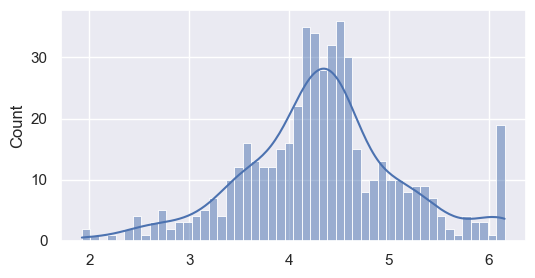

In [26]:
# Plot the boxcox_medv data using seaborn with kde=True
plt.figure(figsize=(6, 3))
sns.histplot(boxcox_medv, kde=True, bins=50);

In [27]:
# normaltest(boxcox_medv)
get_k2test_pvalue(boxcox_medv)

0.104689

We find that the box cox results in a graph which is significantly more normally distributed (according to p value) than the other two distributions.This can be even above 0.05.

Now that we have a normally distributed y-variable, let's test Regression using this transformed target variables.


## Linear Regression


In [39]:
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import (StandardScaler, 
#                                    PolynomialFeatures)

In [29]:
lr = sklearn.linear_model.LinearRegression()

### **Define and load the predictor (X) and Target(y) variables**


In [30]:
y_col = "MEDV"

X = boston_data.drop(y_col, axis=1)
y = boston_data[y_col]

In [31]:
X.shape, y.shape

((506, 13), (506,))

### **Create Polynomial Features**


Let's skip this for now.

In [ ]:
# pf = PolynomialFeatures(degree=2, include_bias=False)
# X_pf = pf.fit_transform(X)

### **Split the data into Training and Test Sets**   

The split ratio here is 0.7 and 0.3 which means we will assign **70%** data for training and **30%** data for testing


In [32]:
# X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, 
#                                                     random_state=72018)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3, 
                                                    random_state=72018)

In [33]:
X.shape, X_train.shape, X_test.shape

((506, 13), (354, 13), (152, 13))

In [34]:
y.shape, y_train.shape, y_test.shape

((506,), (354,), (152,))

### **Normalize the training data using `StandardScaler` on `X_train`. Use fit_transform() function**


In [35]:
s = sklearn.preprocessing.StandardScaler()
X_train_s = s.fit_transform(X_train)


In [39]:
X_test_s = s.transform(X_test)

### **Discuss: what transformation do we need to apply next?**

Apply the appropriate transformation.


In [36]:
# Enter your code here
y_train_bc, lambda_2 = stats.boxcox(y_train)

In [38]:
y_train_bc.shape, get_k2test_pvalue(y_train_bc)

((354,), 0.085992)

<details><summary>Click here for a sample python solution</summary>

```python
    
bc_result2 = boxcox(y_train)
y_train_bc = bc_result2[0]
lam2 = bc_result2[1]

```


As before, we'll now:

1. Fit regression
1. Transform testing data
1. Predict on testing data


In [ ]:
y_train_bc.shape

In [40]:
lr.fit(X_train_s, y_train_bc)
# X_test_s = s.transform(X_test)

LinearRegression()

In [41]:
y_pred_bc = lr.predict(X_test_s)

#### Discussion

* Are we done?
* What did we predict?
* How would you interpret these predictions?


### Apply inverse transformations to be able to use these in a Regression context


Every transformation has an inverse transformation. The inverse transformation of $f(x) = \sqrt{x}$ is $f^{-1}(x) = x^2$, for example. Box cox has an inverse transformation as well: notice that we have to pass in the lambda value that we found from before:


In [ ]:
# from scipy.special import inv_boxcox

In [ ]:
# inv_boxcox(boxcox_medv, lam)[:10]

In [ ]:
# boston_data['MEDV'].values[:10]

Exactly the same, as we would hope!


### Exercise:

1. Apply the appropriate inverse transformation to `y_pred_bc`.
2. Calculate the $R^2$ using the result of this inverse transformation and `y_test`.  

**Hint:** Use the **inv_boxcox()** function to get the transformed predicted values


In [44]:
y_pred_inv_boxcox = scipy.special.inv_boxcox(y_pred_bc, lambda_2)

In [49]:
r2 = sklearn.metrics.r2_score(y_test, y_pred_inv_boxcox)
print(f"R^2: {r2:.4f}")

R^2: 0.7375


<details><summary>Click here for a sample python solution</summary>

```python
y_pred_tran = inv_boxcox(y_pred_bc,lam2)
r2_score(y_test,y_pred_tran)

```


## Practice Exercise: Determine the R^2 of a LinearRegression without the box cox transformation.


In [50]:
# Determine the R^2 of the model without the Box-Cox transformation
lr = sklearn.linear_model.LinearRegression()
lr.fit(X_train_s, y_train) # instead of y_train_bc
y_pred = lr.predict(X_test_s)
r2_no_bc = sklearn.metrics.r2_score(y_test, y_pred)
print(f"R^2 without Box-Cox: {r2_no_bc:.4f}")

R^2 without Box-Cox: 0.6982


<details><summary>Click here for a sample python solution</summary>

```python
lr = LinearRegression()
lr.fit(X_train_s,y_train)
lr_pred = lr.predict(X_test_s)
r2_score(y_test,lr_pred)

```
